# Error Analysis

### Setup + Imports

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from src.metrics import mae, rmse, mape

In [2]:
df = pd.read_csv(
    "../data/processed/hourly_energy.csv",
    parse_dates=["datetime"],
    index_col="datetime"
).sort_index()

target = "Global_active_power"
df.head()

,Global_active_power
datetime,
2006-12-16 17:00:00,4.2229
2006-12-16 18:00:00,3.6322
2006-12-16 19:00:00,3.4002
2006-12-16 20:00:00,3.2686
2006-12-16 21:00:00,3.0565


### Feature Engineering v2

In [3]:
# base time features 
df_feat = df.copy()

df_feat["hour"] = df_feat.index.hour
df_feat["dayofweek"] = df_feat.index.dayofweek
df_feat["month"] = df_feat.index.month

In [4]:
# lag features 
df_feat["lag_1"] = df_feat[target].shift(1)
df_feat["lag_24"] = df_feat[target].shift(24)
df_feat["lag_168"] = df_feat[target].shift(168)

In [5]:
# rolling features 

# rolling mean(24hr)
df_feat["rolling_mean_24"] = (
    df_feat[target]
    .shift(1)
    .rolling(window=24)
    .mean()
)

# rolling std(24hr)
df_feat["rolling_std_24"] = (
    df_feat[target]
    .shift(1)
    .rolling(window=24)
    .std()
)

# rolling mean(7days = 168hours)
df_feat["rolling_mean_168"] = (
    df_feat[target]
    .shift(1)
    .rolling(window=168)
    .mean()
)

In [6]:
# cyclical encoding
df_feat["hour_sin"] = np.sin(2 * np.pi * df_feat["hour"] / 24)
df_feat["hour_cos"] = np.cos(2 * np.pi * df_feat["hour"] / 24)

In [7]:
# drop NaNs
df_feat = df_feat.dropna()
df_feat.shape

(34421, 12)

### Time Split

In [8]:
# create X and y
feature_cols = [
    "dayofweek",
    "month",
    "hour_sin",
    "hour_cos",
    "lag_1",
    "lag_24",
    "lag_168",
    "rolling_mean_24",
    "rolling_std_24",
    "rolling_mean_168"
]

X = df_feat[feature_cols]
y = df_feat[target]

X.head(), y.head()

(                     dayofweek  month  hour_sin      hour_cos   lag_1  lag_24  \
 datetime                                                                        
 2006-12-23 17:00:00          5     12 -0.965926 -2.588190e-01  4.3491  1.4968   
 2006-12-23 18:00:00          5     12 -1.000000 -1.836970e-16  5.4525  2.6870   
 2006-12-23 19:00:00          5     12 -0.965926  2.588190e-01  3.8794  3.9382   
 2006-12-23 20:00:00          5     12 -0.866025  5.000000e-01  4.1178  3.5361   
 2006-12-23 21:00:00          5     12 -0.707107  7.071068e-01  4.1814  4.5487   
 
                      lag_168  rolling_mean_24  rolling_std_24  \
 datetime                                                        
 2006-12-23 17:00:00   4.2229         2.934900        0.990192   
 2006-12-23 18:00:00   3.6322         3.099721        1.066674   
 2006-12-23 19:00:00   3.4002         3.149404        1.074357   
 2006-12-23 20:00:00   3.2686         3.156887        1.080697   
 2006-12-23 21:00:00   3.056

In [9]:
n = len(df_feat)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]

X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

### Load Saved Model + Evaluation

In [ ]:
MODEL_PATH = "../models/forecast_pipeline_v1.joblib"
model = joblib.load(MODEL_PATH)

y_test_pred = model.predict(X_test)

**Build df_val and df_test with residuals**

In [ ]:
df_test = pd.DataFrame({
    "actual": y_test.values,
    "predicted": y_test_pred
}, index=y_test.index)

df_test["residual"] = df_test["actual"] - df_test["predicted"]
df_test["abs_residual"] = np.abs(df_test["residual"])

### Prediction on Peaks

High consumption spikes are typically harder to predict.
We compare model performance on:
- Top 10% highest consumption (peaks)
- Remaining 90% (normal)

In [27]:
# peak analysis 
peak_threshold = np.percentile(df_test["actual"], 90)

df_test["is_peak"] = df_test["actual"] > peak_threshold

rmse_peak = rmse(
    df_test[df_test["is_peak"]]["actual"],
    df_test[df_test["is_peak"]]["predicted"]
)

rmse_non_peak = rmse(
    df_test[~df_test["is_peak"]]["actual"],
    df_test[~df_test["is_peak"]]["predicted"]
)

rmse_peak, rmse_non_peak

(np.float64(0.926589796145575), np.float64(0.37842868573984784))

**Interpretation**

- The RMSE for peak periods is approximately **0.93**, while the RMSE for non-peak periods is approximately **0.38**. This indicates that the model performs significantly worse during high-consumption spikes. Peak periods show more than double the error compared to normal usage periods.

- This suggests that although the model captures general consumption patterns well, it struggles to accurately model sudden or extreme increases in demand. Peaks are likely driven by rare or abrupt behavioral changes that are harder to forecast using historical lag and rolling features alone.

### Weekend Predictions
Energy behavior may differ on weekends.

In [28]:
# weekend analysis 
df_test["dayofweek"] = df_test.index.dayofweek
df_test["is_weekend"] = df_test["dayofweek"] >= 5

rmse_weekend = rmse(
    df_test[df_test["is_weekend"]]["actual"],
    df_test[df_test["is_weekend"]]["predicted"]
)

rmse_weekday = rmse(
    df_test[~df_test["is_weekend"]]["actual"],
    df_test[~df_test["is_weekend"]]["predicted"]
)

rmse_weekend, rmse_weekday

(np.float64(0.5308592941375354), np.float64(0.4344836313704877))

**Interpretation**

- The RMSE for weekends is approximately **0.53**, while the RMSE for weekdays is approximately **0.43**. This shows that the model performs slightly worse on weekends compared to weekdays. The difference is noticeable but not extreme.

- This suggests that weekend consumption patterns differ from weekday behavior and may not be fully captured by the existing features. 

- Additional features such as explicit weekend indicators, holiday flags, or separate modeling for weekends could further improve performance.

### Night-Hours Predictions

Night hours have low consumption.
Small errors may inflate relative error.

In [29]:
df_test["hour"] = df_test.index.hour
df_test["is_night"] = df_test["hour"] <= 5

rmse_night = rmse(
    df_test[df_test["is_night"]]["actual"],
    df_test[df_test["is_night"]]["predicted"]
)

rmse_day = rmse(
    df_test[~df_test["is_night"]]["actual"],
    df_test[~df_test["is_night"]]["predicted"]
)

rmse_night, rmse_day

(np.float64(0.28074052480058675), np.float64(0.5100176541607059))

**Interpretation**

- The RMSE during night hours is approximately **0.28**, while the RMSE during daytime hours is approximately **0.51**. This indicates that the model performs better at night compared to daytime. Night consumption is generally lower and more stable, which makes it easier to predict.

- Daytime usage likely contains more variability due to active appliance usage and human behavior patterns, resulting in higher prediction errors.

### Residual Bias Check 
- If residuals center around 0 → no bias.
- If mostly positive → underprediction bias.
- If mostly negative → overprediction bias.

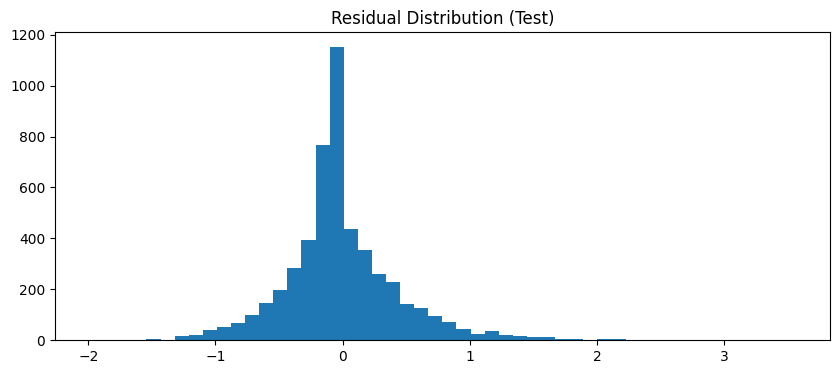

np.float64(-0.009205214390105054)

In [30]:
# residual distributions
plt.figure(figsize=(10,4))
plt.hist(df_test["residual"], bins=50)
plt.title("Residual Distribution (Test)")
plt.show()

df_test["residual"].mean()

**Interpretation**

- The mean residual is approximately **-0.009**, which is very close to zero. This indicates that the model is effectively unbiased overall. It does not consistently overpredict or underpredict energy consumption.

- The residual histogram appears centered around zero, with a roughly symmetric distribution and some heavy tails. This suggests that large errors occur occasionally but are not systematic.

### Residual Over Time

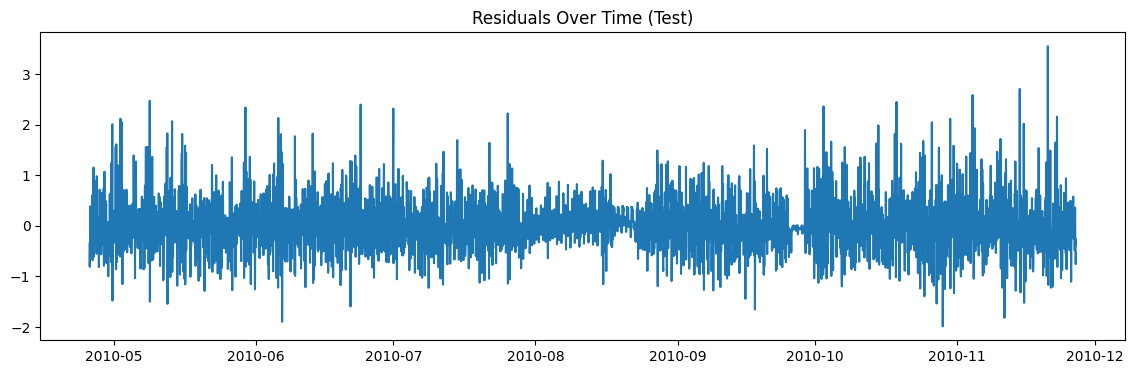

In [31]:
plt.figure(figsize=(14,4))
plt.plot(df_test.index, df_test["residual"])
plt.title("Residuals Over Time (Test)")
plt.show()

**Interpretation**

- The residuals fluctuate around zero throughout the test period, with no clear upward or downward drift. There are clusters of larger residuals, particularly during certain months, which likely correspond to high-demand periods or irregular behavior. 

- However, the absence of consistent bias or trend indicates that the model remains stable over time and does not degrade significantly during the test period.

### Final Error Analysis Conclusion

The error analysis reveals that the forecasting model performs strongly overall but shows predictable weaknesses under specific conditions.

- The model struggles most during peak consumption periods, where prediction error more than doubles compared to normal periods. This suggests that extreme spikes are harder to capture using current lag and rolling statistics.

- Weekend performance is slightly worse than weekday performance, indicating that weekend behavioral patterns are not fully captured by the existing features.

- Night-time predictions are more accurate than daytime predictions, likely due to lower volatility and more stable consumption patterns during night hours.

- The residual distribution is centered around zero, confirming that the model is unbiased and does not systematically overestimate or underestimate energy consumption.

- Residuals remain stable over time with no clear drift, demonstrating that the model generalizes well to unseen data.

Overall, the model is stable, unbiased, and robust, but future improvements should focus on better modeling of extreme peak events and weekend behavioral variations.